### Common imports

In [22]:
%matplotlib inline
%matplotlib notebook
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time

### Provided functions
#### Image loading and saving

In [23]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [24]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [25]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10,2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)

#### Plot the height map

In [26]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

---
### Your implementation

In [27]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    #  subtract the ambient image from each image in the light source stack.
    processed_imarray = imarray - ambient_image[:, :, np.newaxis]
    # set any negative values to zero.
    processed_imarray[processed_imarray < 0] = 0
    # rescale the resulting intensities to between 0 and 1 by dividing 255.
    processed_imarray = processed_imarray / 255
    return processed_imarray

In [28]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h = imarray.shape[0]
    w = imarray.shape[1]
    n_images = imarray.shape[2]
    imarray = imarray.reshape(h*w, n_images).transpose()
    results_array = np.linalg.lstsq(light_dirs, imarray)
    g = results_array[0]
    residual = results_array[1]
    albedo_image = np.linalg.norm(g, axis=0)
    surface_normals = g / albedo_image
    #reshape
    surface_normals = surface_normals.transpose().reshape(h, w, 3)
    albedo_image = albedo_image.reshape(h, w)
    
    return albedo_image, surface_normals, residual

In [29]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    # Partial derivative.
    fx = surface_normals[:,:,0] / surface_normals[:,:,2]
    fy = surface_normals[:,:,1] / surface_normals[:,:,2]
    # 
    if integration_method == 'column':
        # First column, then row.
        height_map = np.cumsum(fx, axis=1) + np.cumsum(fy[:,0])[:,np.newaxis]
    elif integration_method == 'row':
        # First Row, then Column
        height_map = np.cumsum(fy, axis=0) + np.cumsum(fx[0])
    elif integration_method == 'average':
        # take the average of row and column
        height_map_c = np.cumsum(fx, axis=1) + np.cumsum(fy[:,0])[:,np.newaxis]
        height_map_r = np.cumsum(fy, axis=0) + np.cumsum(fx[0])
        height_map = (height_map_c + height_map_r) / 2
    #random   
    else:
        paths = 100
        h=surface_normals.shape[0]
        w=surface_normals.shape[1]
        height_map = np.zeros((h, w))
        for path in range(paths):
            s_h = np.random.randint(h)
            s_w = np.random.randint(w)
            if np.random.randint(2) == 0:
                tmp = np.zeros((h, w))
                
                tmp[:,s_w:] = tmp[:,s_w:]+np.cumsum(fx[s_h,s_w:])
                tmp[:,:s_w] = tmp[:,:s_w]-np.flip(np.cumsum(np.flip(fx[s_h,:s_w])))
                
                tmp[s_h:] = tmp[s_h:]+ np.cumsum(fy[s_h:], axis=0)
                tmp[:s_h] = tmp[:s_h]-np.flip(np.cumsum(np.flip(fy[:s_h]), axis=0))
                
                tmp -= tmp[0][0]
                height_map += tmp / paths
            else:
                tmp = np.zeros((h, w))
                
                tmp[s_h:] = tmp[s_h:]+np.cumsum(fy[s_h:,s_w])[:,np.newaxis]
                tmp[:s_h] = tmp[:s_h]- np.flip(np.cumsum(np.flip(fy[:s_h,s_w])))[:,np.newaxis]
                tmp[:,s_w:] = tmp[:,s_w:]+np.cumsum(fx[:,s_w:], axis=1)
                tmp[:,:s_w] =tmp[:,:s_w]- np.flip(np.cumsum(np.flip(fx[:,:s_w]), axis=1))
                
                tmp -= tmp[0][0]
                height_map += tmp / paths
                
    return height_map

### Main function

# Outputs for yaleB02 in 4 methods

running times: 4 methods
mean residual: 4 subjects

In [57]:
root_path = './croppedyale/'
subject_name = 'yaleB02' 
integration_method = 'random' #['row', 'column', 'average', 'random']
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)
start = time.time()
processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual02 = photometric_stereo(processed_imarray,
                                                   light_dirs)
# print("Mean Residual:".format(residual))
print('Residual02: {} s.'.format(residual02))

avg02 = np.mean(residual02)
print('Mean Residual 02: {} s.'.format(avg02))

height_map = get_surface(surface_normals, integration_method)

end = time.time()
# print("Time elapsed:".format(end-start))
print('running time: {} s.'.format(end-start))

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

Residual02: [3.50655175 3.73233923 3.84367386 ... 3.41668541 3.44334959 5.26235031] s.
Mean Residual 02: 1.9255070032128052 s.
running time: 0.06388497352600098 s.


/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


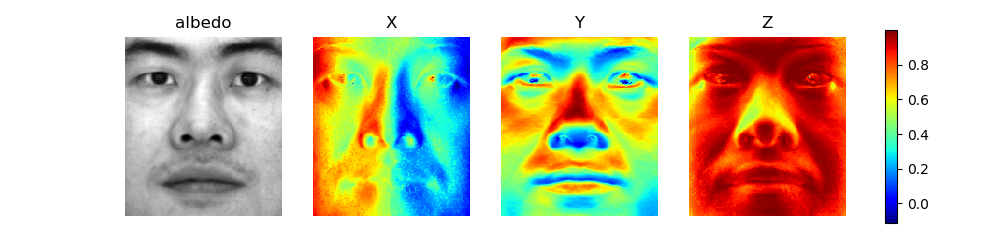

In [55]:
plot_albedo_and_surface_normals(albedo_image, surface_normals)

<IPython.core.display.Javascript object>


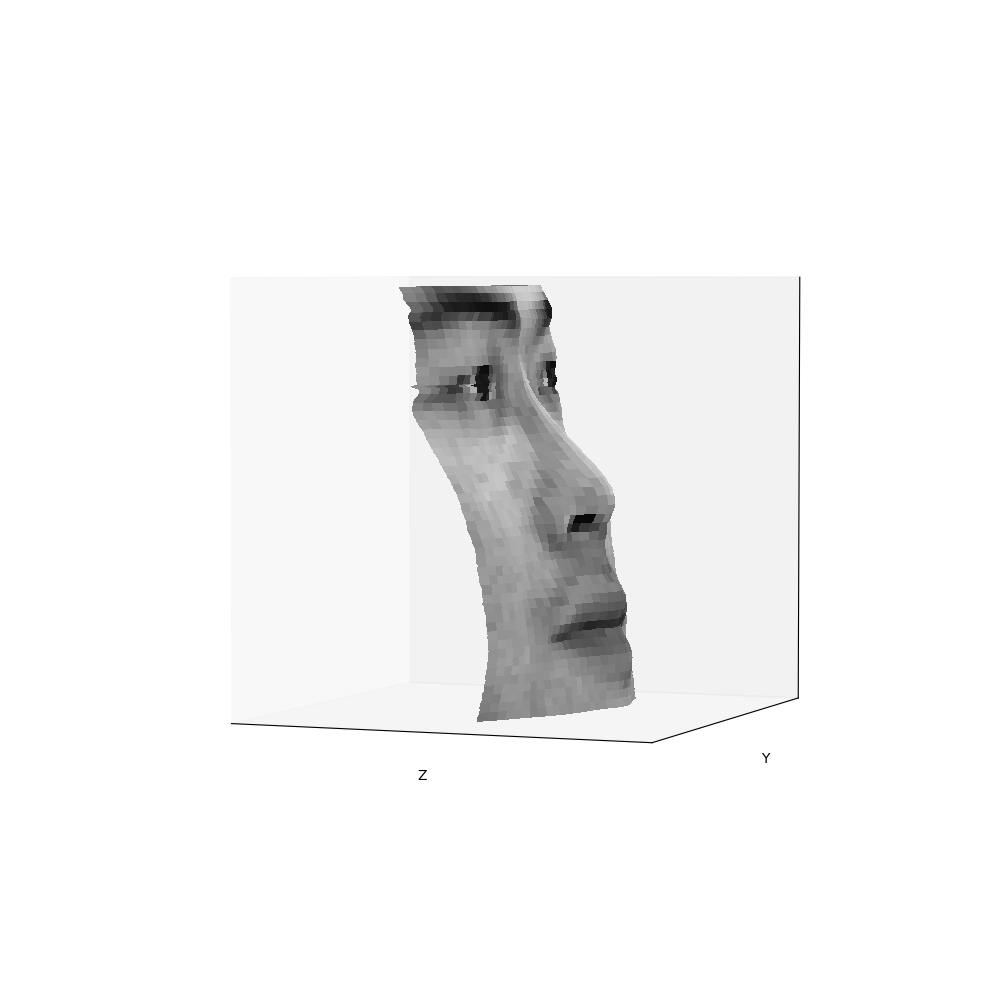

In [51]:
%matplotlib notebook
display_3d(albedo_image, height_map)

# Other Subjects: yaleB01

In [58]:
root_path = './croppedyale/'
subject_name = 'yaleB01' 
integration_method = 'random' #['row', 'column', 'average', 'random']
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual01 = photometric_stereo(processed_imarray,
                                                   light_dirs)
print('Residual01: {} s.'.format(residual01))

avg01 = np.mean(residual01)
print('Mean Residual 01: {} s.'.format(avg01))

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)



Residual01: [3.89114736 3.85086103 3.78552921 ... 0.68620166 0.9125245  1.09458203] s.
Mean Residual 01: 1.8196826076250108 s.


/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


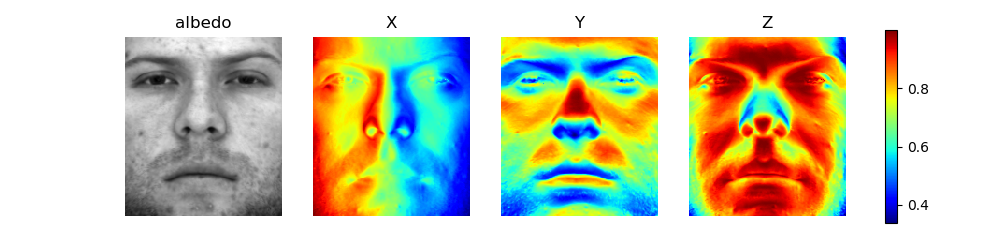

In [59]:
plot_albedo_and_surface_normals(albedo_image, surface_normals)

<IPython.core.display.Javascript object>


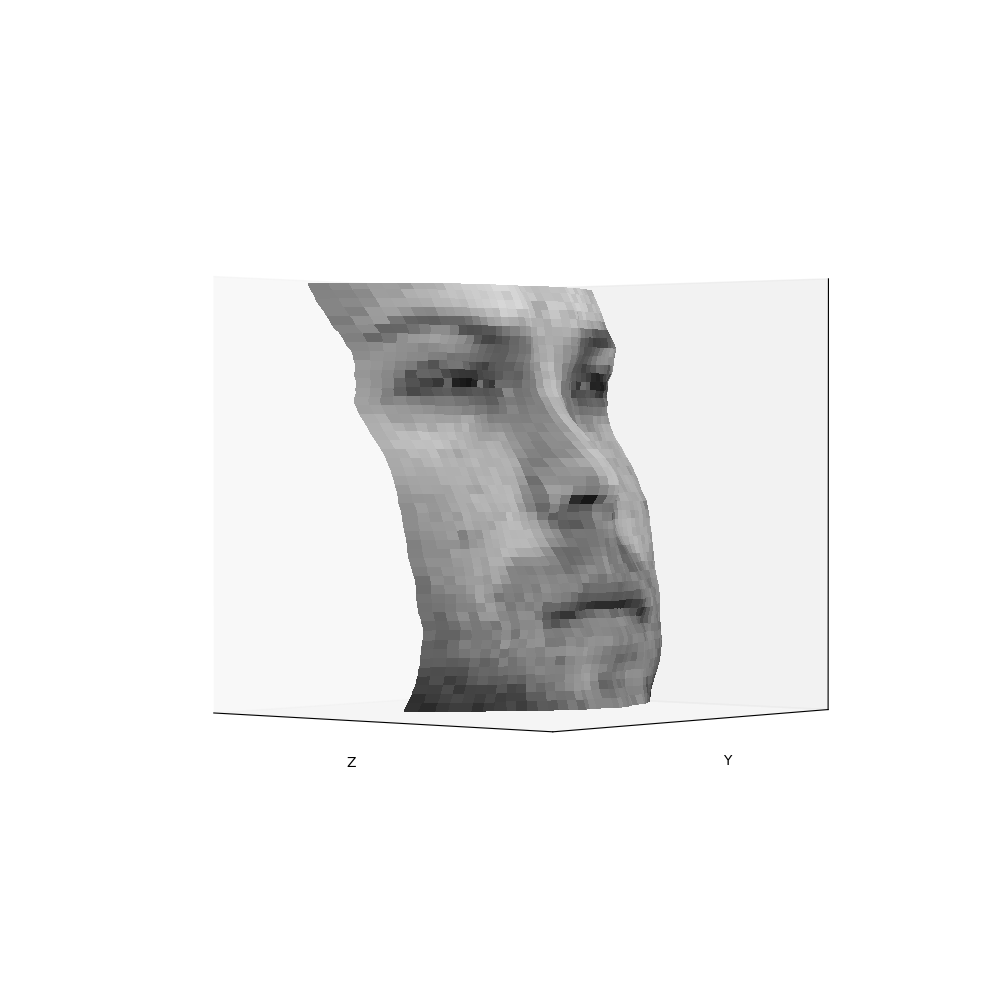

In [60]:
%matplotlib notebook
display_3d(albedo_image, height_map)

# yaleB05

Residual05: [0.07226909 0.06094514 0.06670223 ... 5.71273971 5.87729256 6.01075345] s.
Mean Residual 05: 1.6902902287341741 s.


/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


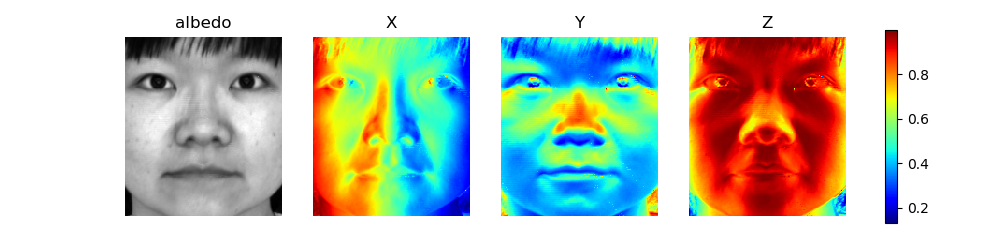

In [61]:
root_path = './croppedyale/'
subject_name = 'yaleB05' #[1, 2, 5, 7]
integration_method = 'random' #['row', 'column', 'average', 'random']
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual05 = photometric_stereo(processed_imarray,
                                                   light_dirs)
print('Residual05: {} s.'.format(residual05))

avg05 = np.mean(residual05)
print('Mean Residual 05: {} s.'.format(avg05))

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

plot_albedo_and_surface_normals(albedo_image, surface_normals)

<IPython.core.display.Javascript object>


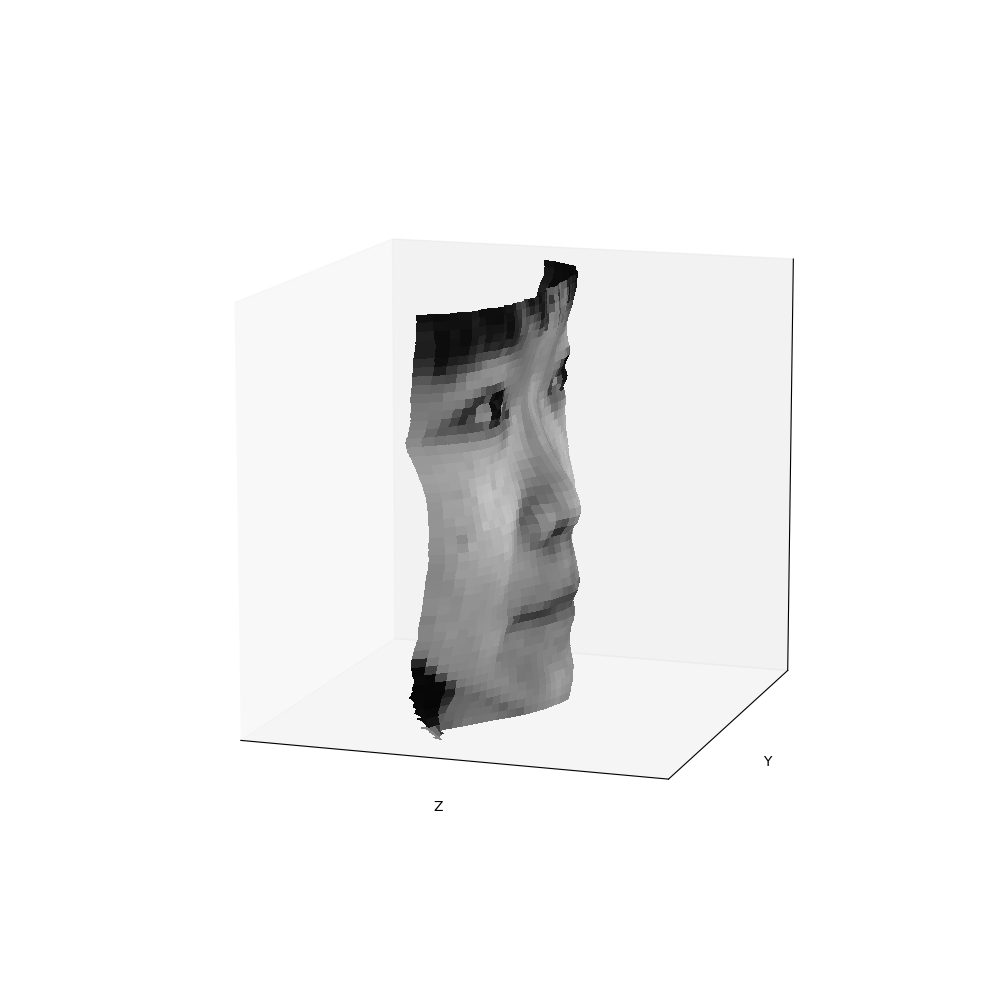

In [62]:
%matplotlib notebook
display_3d(albedo_image, height_map)

# yaleB07

Residual07: [3.53724003e+00 3.30711750e+00 2.98129715e+00 ... 1.54664029e+01
 8.76307095e-03 1.66852855e-02] s.
Mean Residual 07: 1.4576228512311087 s.


/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


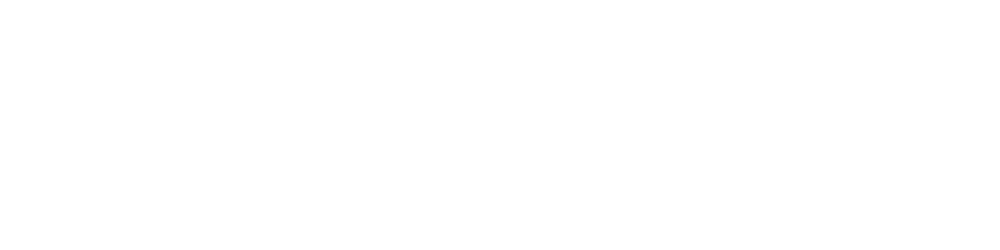

In [63]:
root_path = './croppedyale/'
subject_name = 'yaleB07' 
integration_method = 'random' #['row', 'column', 'average', 'random']
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual07 = photometric_stereo(processed_imarray,
                                                   light_dirs)
print('Residual07: {} s.'.format(residual07))
avg07 = np.mean(residual07)
print('Mean Residual 07: {} s.'.format(avg07))

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

plot_albedo_and_surface_normals(albedo_image, surface_normals)

<IPython.core.display.Javascript object>


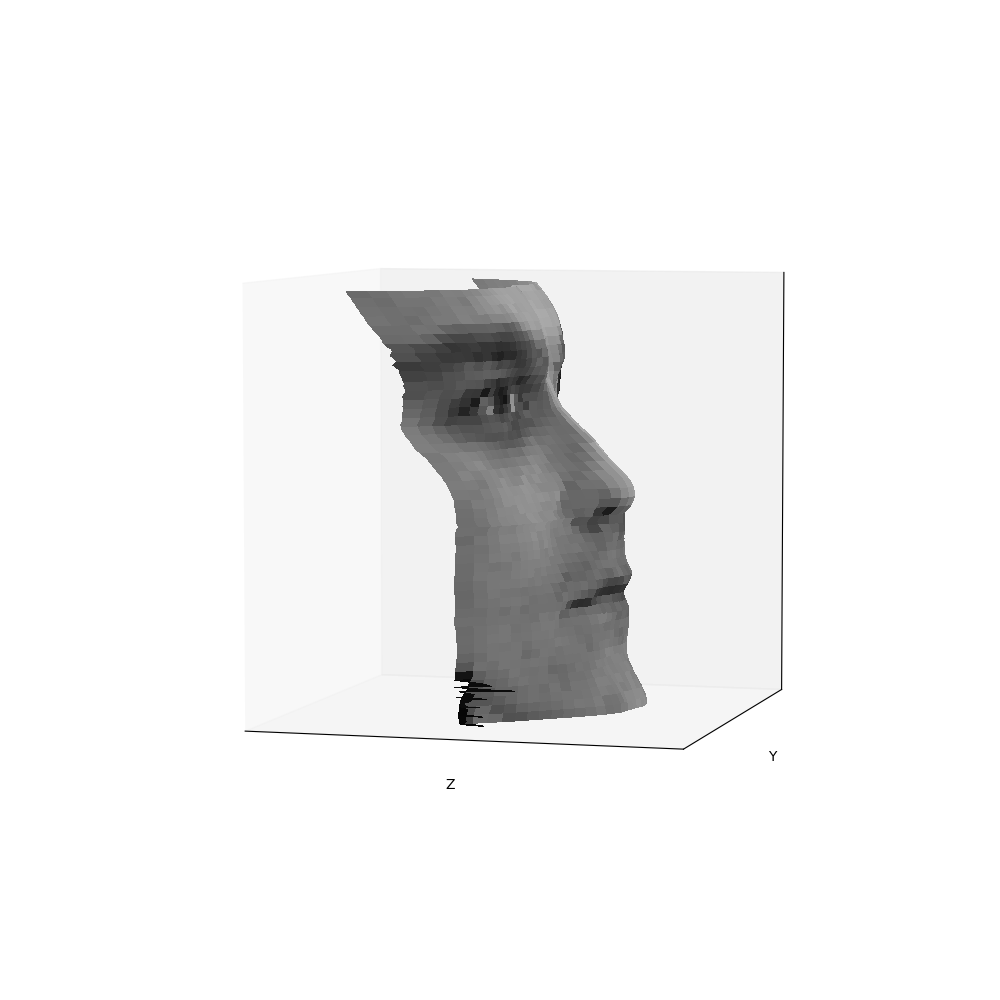

In [64]:
%matplotlib notebook
display_3d(albedo_image, height_map)

# Part(e) Subset

/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


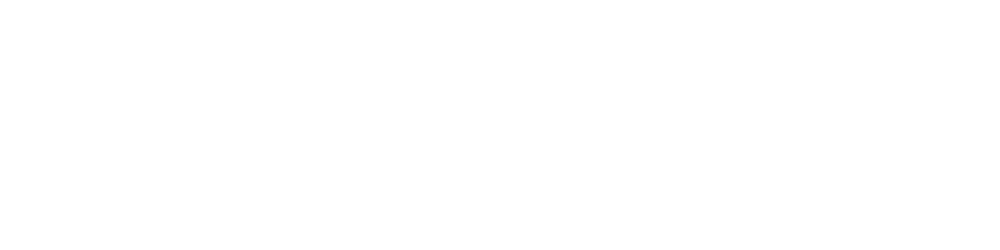

<IPython.core.display.Javascript object>


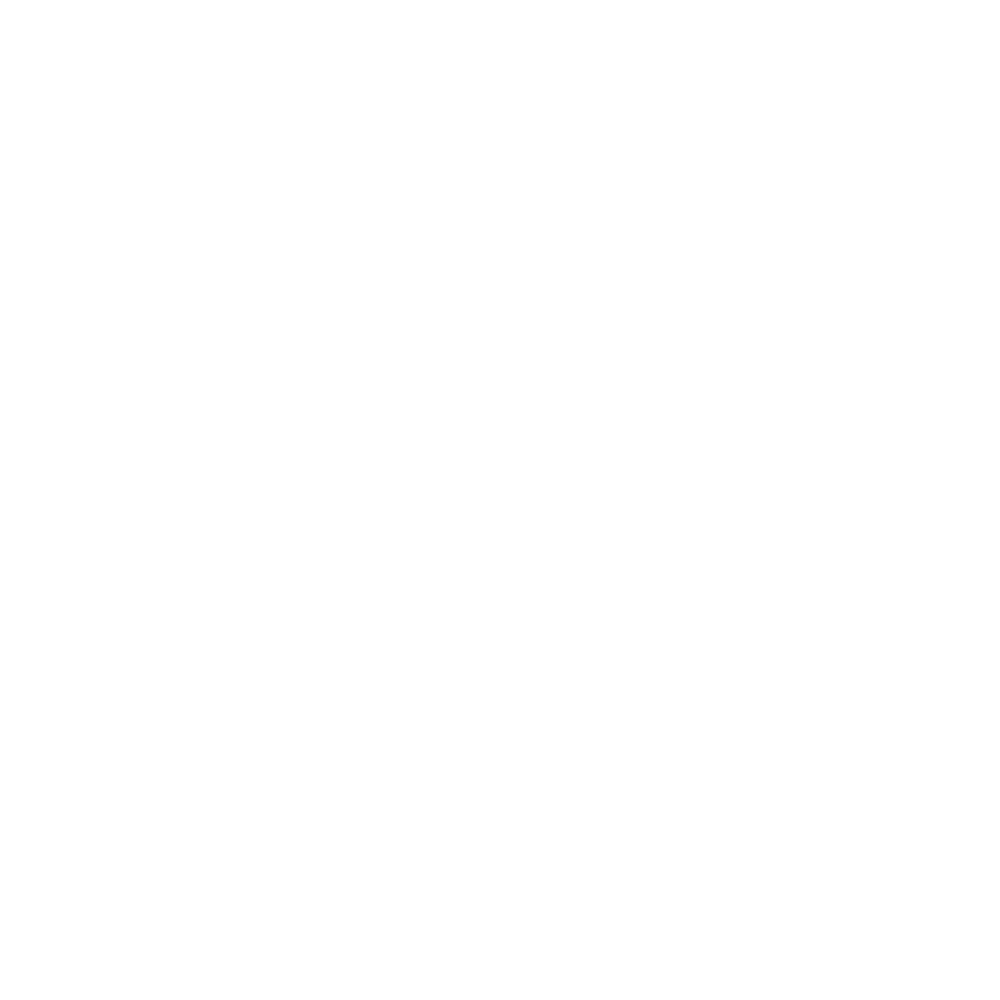

In [19]:
root_path = './croppedyale/'
subject_name = 'yaleB05'
integration_method = 'random'
save_flag = True

full_path = '%s%s%s' % (root_path, subject_name, '_subset')
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,39)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

plot_albedo_and_surface_normals(albedo_image, surface_normals)

%matplotlib notebook
display_3d(albedo_image, height_map)

# EC3 Misalignment

/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


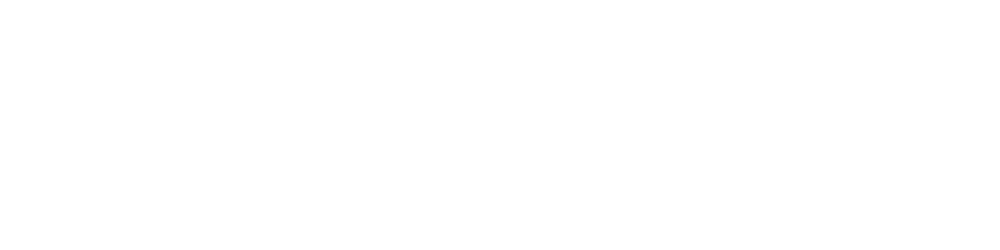

<IPython.core.display.Javascript object>


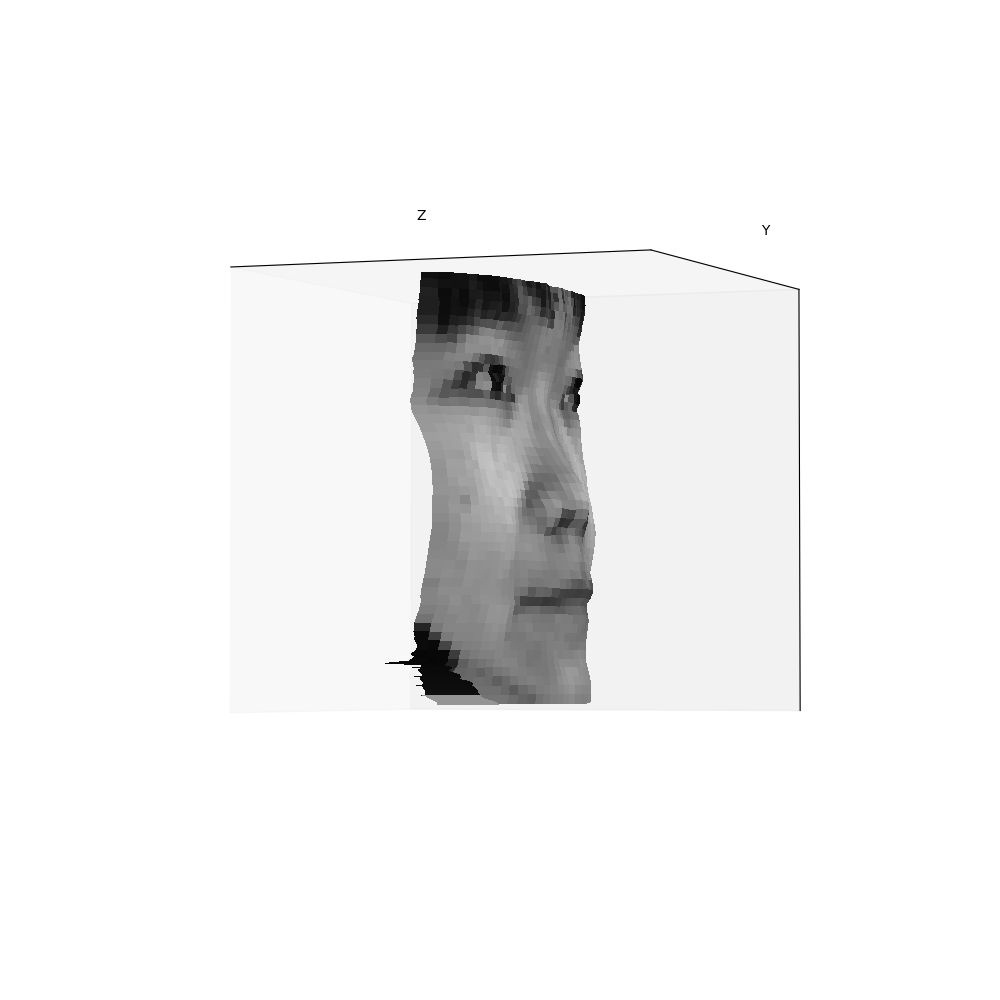

In [68]:
root_path = './croppedyale/'
subject_name = 'yaleB05'
integration_method = 'random'
save_flag = True

full_path = '%s%s%s' % (root_path, subject_name, '_misalignment')
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,52)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

plot_albedo_and_surface_normals(albedo_image, surface_normals)

%matplotlib notebook
display_3d(albedo_image, height_map)

# EC4 Assumption

/Users/wangyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<IPython.core.display.Javascript object>


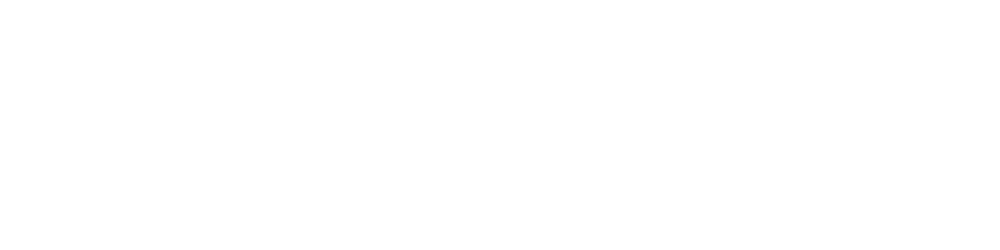

<IPython.core.display.Javascript object>


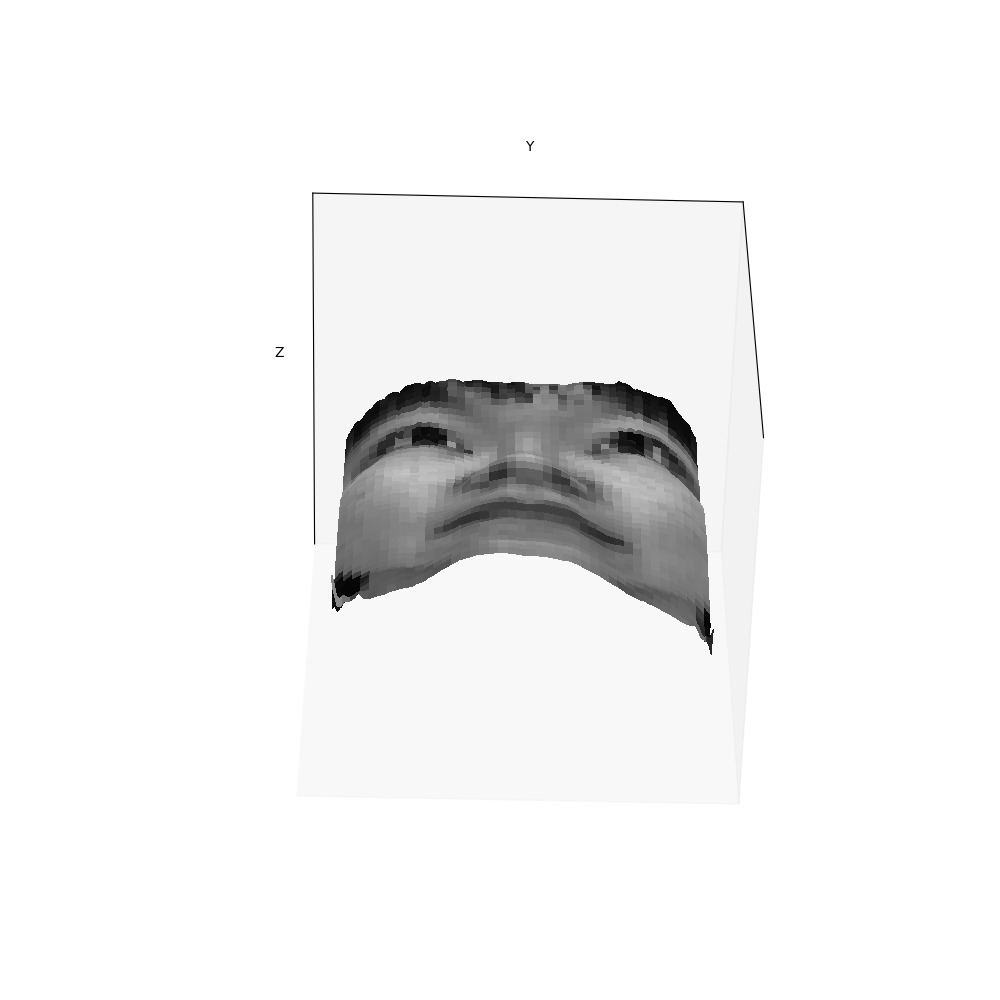

In [72]:
root_path = './croppedyale/'
subject_name = 'yaleB05'
integration_method = 'random'
save_flag = True

full_path = '%s%s%s' % (root_path, subject_name, '_assumption')
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,45)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals,residual = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

plot_albedo_and_surface_normals(albedo_image, surface_normals)

%matplotlib notebook
display_3d(albedo_image, height_map)